<a href="https://colab.research.google.com/github/saritmaitra/Forex_VAR-VECM/blob/main/VAR__FORECAST_logdiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
import math
from pandas import DataFrame, merge, concat
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# 1. Data loading and initial preprocessing:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data.csv


In [ ]:
print('view data...')
df = pd.read_csv("AL_final_data.csv")
df.head()

view data...


<IPython.core.display.Javascript object>

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
0,0,2020-05-01 00:00:00,2877.125,1094465.0,1258140.0,1695.85,8846.125,107301000.0
1,1,2020-05-01 00:01:00,2875.375,1094215.0,1257935.0,1695.60,8841.250,107368000.0
2,2,2020-05-01 00:02:00,2874.625,1094165.0,1257765.0,1695.65,8837.750,107376500.0
3,3,2020-05-01 00:03:00,2874.125,1094115.0,1257565.0,1695.40,8836.750,107381500.0
4,4,2020-05-01 00:04:00,2875.250,1094190.0,1257535.0,1694.85,8841.125,107376500.0


In [ ]:
print('dropping unnecessary column...')
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.tail()

dropping unnecessary column...


,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
29340,2020-05-29 20:56:00,3027.25,1111740.0,1235400.0,1731.50,9588.625,107675000.0
29341,2020-05-29 20:57:00,3027.25,1111750.0,1235450.0,1731.20,9588.500,107830000.0
29342,2020-05-29 20:58:00,3027.25,1111650.0,1235450.0,1731.45,9588.625,107830000.0
29343,2020-05-29 20:59:00,3027.25,1113400.0,1235450.0,1731.30,9587.375,107835000.0
29344,2020-05-29 21:00:00,3027.25,1113400.0,1237150.0,1731.35,9591.125,107835000.0


In [ ]:
print('setting datetime index....')
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

setting datetime index....


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [ ]:
print('dropping duplicates (if any)...')
df.drop_duplicates(keep=False)
df.info()

dropping duplicates (if any)...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [ ]:
df = df.sort_index(ascending=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

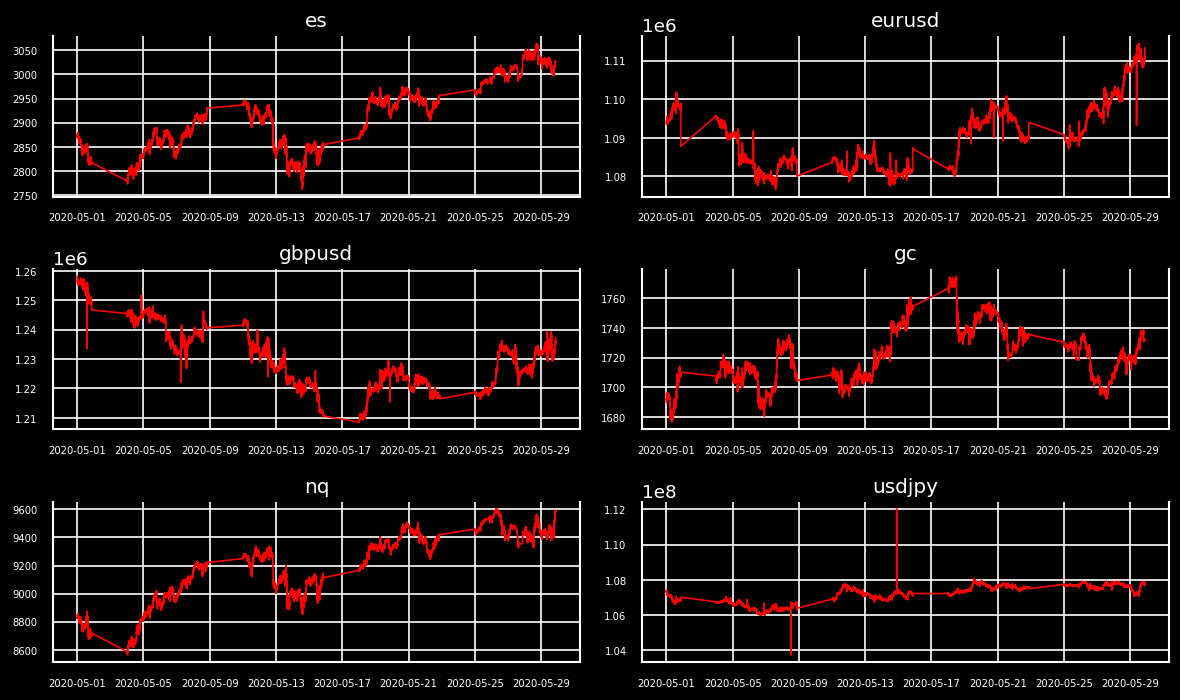

In [ ]:
# Plot
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    dataset = df[df.columns[i]]
    ax.plot(dataset, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

We had seen earlier during exploratory analysis and more so, Visually it can be assumed that, none of the original series are stationary and have Brownian motion movement.

# 1 Multicolinearity
### 1.1 Pearson Correlation:

correlation matrix (Original series):

          es  eurusd  gbpusd    gc    nq  usdjpy
es      1.00    0.68   -0.24  0.12  0.90    0.66
eurusd  0.68    1.00    0.09  0.04  0.44    0.51
gbpusd -0.24    0.09    1.00 -0.68 -0.54   -0.53
gc      0.12    0.04   -0.68  1.00  0.34    0.36
nq      0.90    0.44   -0.54  0.34  1.00    0.72
usdjpy  0.66    0.51   -0.53  0.36  0.72    1.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

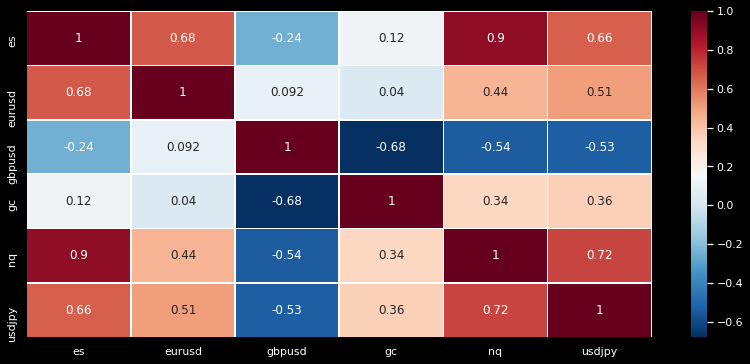

In [ ]:
col = df.copy()
print('correlation matrix (Original series):'); print()
print(col.corr())

plt.style.use('dark_background')
plt.figure(figsize = (14,6)); print()
pearsoncorr = col.corr(method='pearson')
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',annot=True,linewidth=0.5)
plt.show()

we have seen this earlier during exploratory analysis that, the largest observed correlations (in absolute value) are:
- 0.90 between ES & NQ;
- 0.68 between the EURUSD & ES; 
- 0.90 between NQ & ES;
- 0.72 between USDJPY & NQ; 
- 0.66 between USDJPY & ES 
- 0.68 between GBPUSD & GC (negative significant correlation)

We have considered >6 as significant correlation.

We shall recheck the correlation later on transformed dataset.

## 1.1 Histograms and Density plots:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

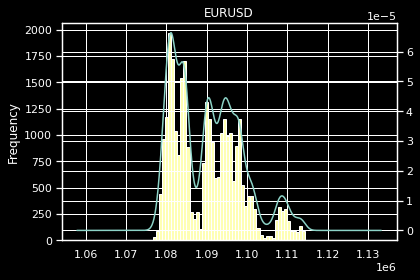

In [ ]:
plt.style.use('dark_background')
ax = df.eurusd.plot(kind='kde', secondary_y=True)
df.eurusd.plot(kind='hist', bins=50)
plt.title('EURUSD')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

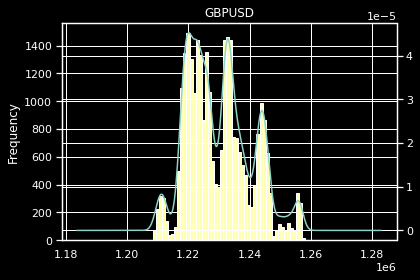

In [ ]:
plt.style.use('dark_background')
ax = df.gbpusd.plot(kind='kde', secondary_y=True)
df.gbpusd.plot(kind='hist', bins=50)
plt.title('GBPUSD')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

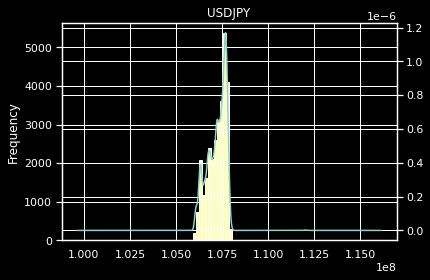

In [ ]:
plt.style.use('dark_background')
ax = df.usdjpy.plot(kind='kde', secondary_y=True)
df.usdjpy.plot(kind='hist', bins=50)
plt.title('USDJPY')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

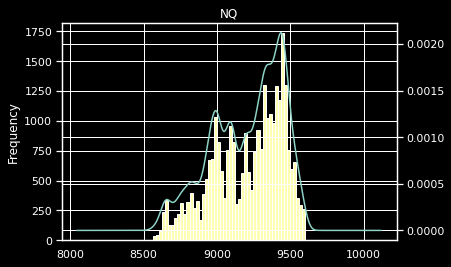

In [ ]:
plt.style.use('dark_background')
ax = df.nq.plot(kind='kde', secondary_y=True)
df.nq.plot(kind='hist', bins=50)
plt.title('NQ')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

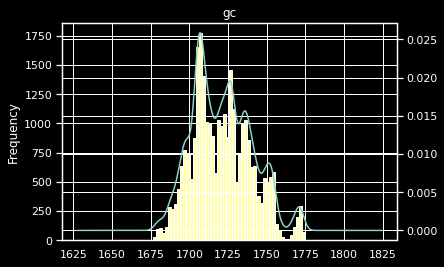

In [ ]:
plt.style.use('dark_background')
ax = df.gc.plot(kind='kde', secondary_y=True)
df.gc.plot(kind='hist', bins=50)
plt.title('gc')
plt.show()

## 1.2 Normality test:

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

"""
General guideline for skewness:
if the number > +1 or < –1, this is an indication of a substantially skewed distribution. 
For kurtosis:
if the number > +1, the distribution is too peaked. 
Likewise, a kurtosis of < –1 indicates a distribution that is too flat. 
Distributions exhibiting skewness and/or kurtosis that exceed these guidelines are considered nonnormal.
Ref: (Hair et al., 2017, p. 61).
"""
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(df)
lzip(name, test)

[('Jarque-Bera', array([1254., 1997., 1211.,  814., 1950., 5055.])),
 ('Chi^2 two-tail prob.',
  array([4.e-273, 0.e+000, 1.e-263, 1.e-177, 0.e+000, 0.e+000])),
 ('Skew', array([ 0.,  1.,  0.,  0., -1., -0.])),
 ('Kurtosis', array([2., 3., 3., 3., 2., 5.]))]

- skewness is positive in 4 series (ES, EURUSD, GBPUSD, GC); the data are skewed right, meaning that the right tail of the distribution is longer than the left. 
- skewness is negative in 2 series (NQ, USDJPY); the data are skewed left, meaning that the left tail of the distribution is longer than the right.

here are the general assumptions:
- skewness is less than −1 or greater than +1, the distribution is highly skewed.
- skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
- kewness is between −½ and +½, the distribution is approximately symmetric.

Going by skew values (0.10577135,  0.62682264,  0.46015031,  0.37613819, -0.53754677, -0.28981428), we can assume that our data distribution is approximately symmetric.

In [ ]:
# mean, std and IQR values
df.describe()

,es,eurusd,gbpusd,gc,nq,usdjpy
count,29345.00,29345.00,29345.00,29345.00,29345.00,29345.00
mean,2915.07,1090105.98,1229981.59,1721.17,9207.19,107209891.12
std,70.37,8343.41,10285.19,19.11,241.11,505815.85
min,2761.62,1076660.00,1208510.00,1676.50,8563.75,103750000.00
25%,2853.88,1082605.00,1221710.00,1706.55,9016.50,106833500.00
50%,2916.88,1089900.00,1228400.00,1720.00,9265.12,107312000.00
75%,2963.38,1095825.00,1236420.00,1734.75,9410.00,107647000.00
max,3064.38,1114440.00,1258140.00,1774.85,9601.88,112017500.00


In [ ]:
# spliting train/test
#nobs = 10 # keeping 10 mins observations aside for validation
#train_var, test_var = df[0:- nobs], df[- nobs:]

#train_trans = np.log(train_var).diff().dropna()
#print('Description of diff data:'); print(train_trans.describe());

In [ ]:
#train_trans = np.log(train_var/train_var.shift(1)).dropna()
#train_trans

## 1.1 Spliting train/test



In [ ]:
# spliting train/test
nobs = 10 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
print(train_var.shape, test_var.shape); print()

"""
stationary time series means a constant mean and variance over time, which makes it easy for predicting values.
"""

# transfoming training data set
train_log = np.log(train_var) # log transformation

"""
Performed log transformation to normalize skewed variables. Our varibales here having non-linear relationships.
So, while modeling, the chances of producing errors may also be skewed negatively. 
We want to produce the smallest error possible when making prediction, moreover, we should not be overfitting the model. 
"""

train_trans = train_log.diff().dropna() # 1st order differencing

"""
finding the differences between consecutive values of the series
"""
print('Description of diff data:'); print(train_trans.describe());

(29335, 6) (10, 6)



<IPython.core.display.Javascript object>

Description of diff data:
            es   eurusd   gbpusd       gc       nq   usdjpy
count 29334.00 29334.00 29334.00 29334.00 29334.00 29334.00
mean      0.00     0.00    -0.00     0.00     0.00     0.00
std       0.00     0.00     0.00     0.00     0.00     0.00
min      -0.01    -0.02    -0.01    -0.01    -0.02    -0.04
25%      -0.00    -0.00    -0.00    -0.00    -0.00    -0.00
50%       0.00     0.00     0.00     0.00     0.00     0.00
75%       0.00     0.00     0.00     0.00     0.00     0.00
max       0.01     0.02     0.01     0.01     0.01     0.04


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

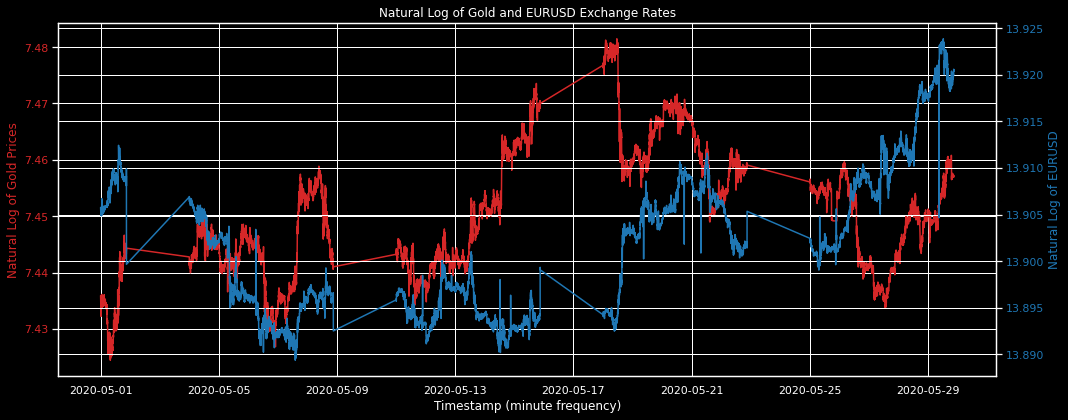

In [ ]:
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize = (15,6))

color = 'tab:red'
ax1.set_xlabel('Timestamp (minute frequency)')
ax1.set_ylabel('Natural Log of Gold Prices', color = color)
ax1.plot(train_log.gc, color=color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Natural Log of EURUSD', color = color)  
ax2.plot(train_log.eurusd, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Natural Log of Gold and EURUSD Exchange Rates')
fig.tight_layout()  
plt.show()

Gold & EURUSD seem appear inversely related over time. When one goes up, the other goes down.

We need to test structural break i.e. when series abruptly changes at a point in time. This change could involve a change in mean or a change in the other parameters of the process that produce the series.

If we can detect when the structure of the series changes can help help us to determine when and whether there is a significant change in our data.

### 1.1.1 Multi-collinearity check on differenced data:

correlation matrix (differenced data):
         es  eurusd  gbpusd    gc   nq  usdjpy
es     1.00    0.06    0.17  0.09 0.89    0.05
eurusd 0.06    1.00    0.15  0.06 0.05   -0.02
gbpusd 0.17    0.15    1.00  0.08 0.16   -0.03
gc     0.09    0.06    0.08  1.00 0.11   -0.04
nq     0.89    0.05    0.16  0.11 1.00    0.04
usdjpy 0.05   -0.02   -0.03 -0.04 0.04    1.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

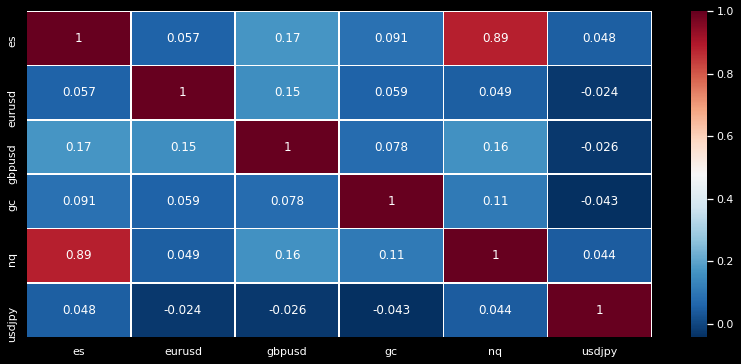

In [ ]:
# rechecking correlation on transformed data
col = train_trans.copy()
print('correlation matrix (differenced data):')
print(col.corr())
plt.figure(figsize = (14,6)); print()
pearsoncorr = col.corr(method='pearson')
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',annot=True,linewidth=0.5)
plt.show()

- The largest obseved +ve correlation is 0.88 between GC and ES. Therefore, we will keep one and drop other.
- largest observerd -ve correlaion is -0.024 between EURUSD and USDJPY which is small enough to ignore.
 

In [ ]:
# dropping ES from transformed dataset
#train_trans.drop(columns = ['es'], axis=1, inplace=True)
#print(train_trans.corr()) # rechecking correlation

Now the observed correlations are quite small and that they can reasonably be ignored.
## 1.2 Lag order selection:

### 1.2.1 Checking required lags through ACF/PACF:


<IPython.core.display.Javascript object>

     acf  pacf  Ljung-Box Q stat  p-val
0  -0.33 -0.33           3272.01   0.00
1  -0.03 -0.16           3294.34   0.00
2  -0.02 -0.10           3307.40   0.00
3  -0.01 -0.06           3308.42   0.00
4   0.01 -0.03           3309.43   0.00
5  -0.00 -0.02           3309.49   0.00
6  -0.00 -0.01           3309.58   0.00
7  -0.01 -0.02           3315.33   0.00
8   0.01 -0.01           3318.34   0.00
9   0.00  0.00           3318.83   0.00
10 -0.00  0.00           3318.86   0.00
11 -0.01 -0.01           3319.74   0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

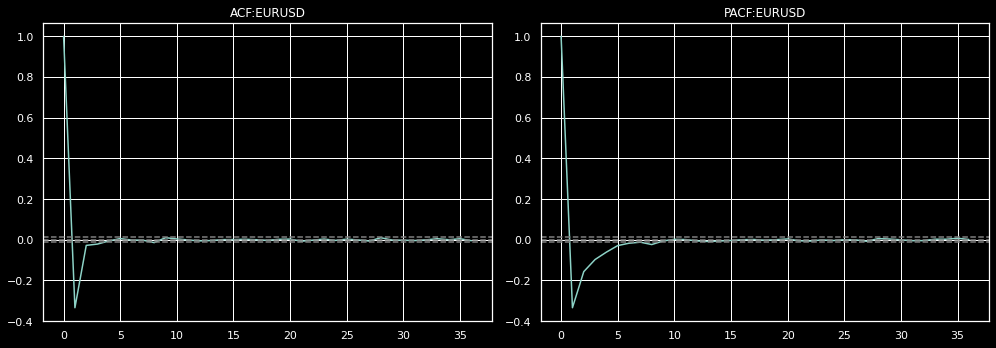

In [ ]:
import statsmodels.tsa.api as smt
from pandas.testing import assert_frame_equal

acf,q,pval = smt.acf(train_trans['eurusd'],nlags=12,qstat=True, fft=False)
pacf = smt.pacf(train_trans['eurusd'],nlags=12)
correlogram = pd.DataFrame({'acf':acf[1:], 'pacf':pacf[1:], 'Ljung-Box Q stat':q,'p-val':pval})
print(correlogram)

from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.eurusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.eurusd, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('ACF:EURUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('PACF:EURUSD')
plt.tight_layout()

It is evident that the series is quite persistent. The autocorrelation function dies away rather quickly. The numerical values of the autocorrelation and partial autocorrelation coefficients at lags 1--12 are given in the second and forth columns of the output, with the lag length given in the first column.

The first acf coefficient is highly significant, the joint test statistic presented in column 3 rejects the null hypothesis of no autocorrelation at the 1{%} level for all numbers of lags considered.


<IPython.core.display.Javascript object>

     acf  pacf  Ljung-Box Q stat  p-val
0  -0.28 -0.28           2342.92   0.00
1  -0.02 -0.11           2356.94   0.00
2   0.01 -0.03           2358.44   0.00
3  -0.01 -0.02           2359.94   0.00
4  -0.01 -0.02           2362.14   0.00
5   0.00 -0.01           2362.15   0.00
6  -0.01 -0.02           2366.98   0.00
7  -0.01 -0.02           2368.12   0.00
8   0.01 -0.00           2369.06   0.00
9   0.00 -0.00           2369.09   0.00
10 -0.00 -0.00           2369.09   0.00
11  0.00  0.00           2369.49   0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

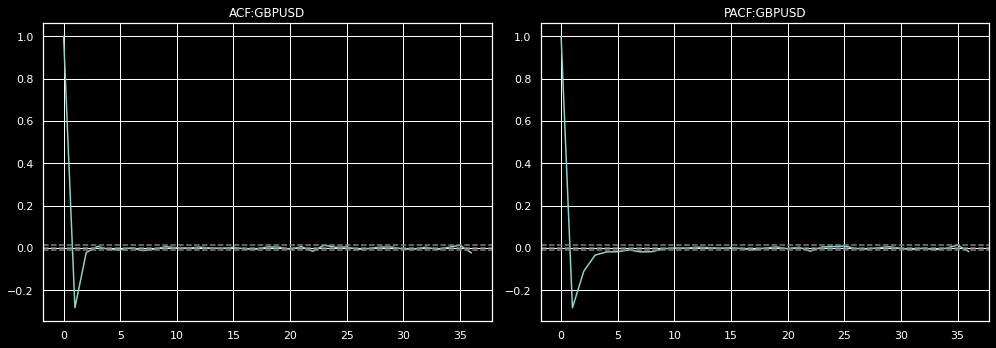

In [ ]:
import statsmodels.tsa.api as smt
acf,q,pval = smt.acf(train_trans['gbpusd'],nlags=12,qstat=True, fft=False)
pacf = smt.pacf(train_trans['gbpusd'],nlags=12)
correlogram = pd.DataFrame({'acf':acf[1:], 'pacf':pacf[1:], 'Ljung-Box Q stat':q,'p-val':pval})
print(correlogram)

from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.gbpusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.gbpusd, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('ACF:GBPUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('PACF:GBPUSD')
plt.tight_layout()

<IPython.core.display.Javascript object>

     acf  pacf  Ljung-Box Q stat  p-val
0  -0.13 -0.13            495.50   0.00
1  -0.01 -0.02            496.83   0.00
2   0.00 -0.00            497.05   0.00
3  -0.00 -0.00            497.08   0.00
4  -0.00 -0.00            497.12   0.00
5  -0.01 -0.01            498.78   0.00
6   0.00  0.00            498.92   0.00
7  -0.00 -0.00            499.24   0.00
8   0.00  0.00            499.65   0.00
9  -0.33 -0.34           3749.25   0.00
10  0.00 -0.10           3749.27   0.00
11 -0.00 -0.03           3749.27   0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

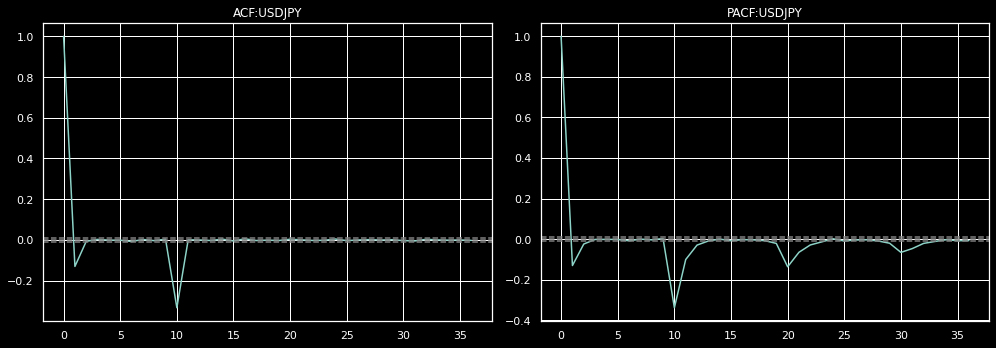

In [ ]:
import statsmodels.tsa.api as smt
acf,q,pval = smt.acf(train_trans['usdjpy'],nlags=12,qstat=True, fft=False)
pacf = smt.pacf(train_trans['usdjpy'],nlags=12)
correlogram = pd.DataFrame({'acf':acf[1:], 'pacf':pacf[1:], 'Ljung-Box Q stat':q,'p-val':pval})
print(correlogram)

from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.usdjpy, nlags=36, fft=False)
lag_pacf = pacf(train_trans.usdjpy, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('ACF:USDJPY')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('PACF:USDJPY')
plt.tight_layout()

<IPython.core.display.Javascript object>

     acf  pacf  Ljung-Box Q stat  p-val
0  -0.01 -0.01              2.23   0.14
1  -0.03 -0.03             29.11   0.00
2  -0.02 -0.02             36.62   0.00
3  -0.01 -0.01             42.03   0.00
4  -0.00 -0.00             42.22   0.00
5  -0.01 -0.01             45.79   0.00
6  -0.00 -0.00             46.03   0.00
7  -0.01 -0.01             49.03   0.00
8   0.00  0.00             49.05   0.00
9  -0.00 -0.01             49.62   0.00
10  0.01  0.01             50.93   0.00
11  0.01  0.01             53.40   0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

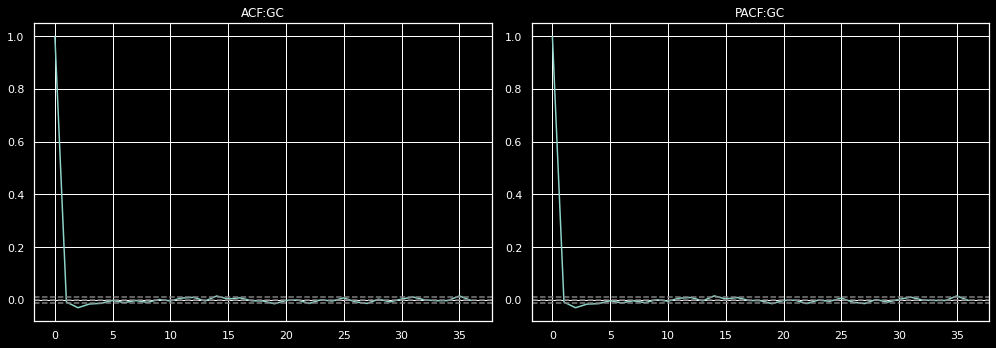

In [ ]:
import statsmodels.tsa.api as smt
acf,q,pval = smt.acf(train_trans.gc,nlags=12,qstat=True, fft=False)
pacf = smt.pacf(train_trans.gc,nlags=12)
correlogram = pd.DataFrame({'acf':acf[1:], 'pacf':pacf[1:], 'Ljung-Box Q stat':q,'p-val':pval})
print(correlogram)

from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.gc, nlags=36, fft=False)
lag_pacf = pacf(train_trans.gc, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('ACF:GC')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('PACF:GC')
plt.tight_layout()

<IPython.core.display.Javascript object>

     acf  pacf  Ljung-Box Q stat  p-val
0   0.02  0.02             17.72   0.00
1  -0.01 -0.01             18.81   0.00
2  -0.01 -0.01             21.22   0.00
3  -0.00  0.00             21.22   0.00
4  -0.00 -0.01             21.93   0.00
5  -0.00 -0.00             22.64   0.00
6  -0.01 -0.01             23.82   0.00
7  -0.00 -0.00             23.89   0.00
8  -0.01 -0.01             27.59   0.00
9  -0.00 -0.00             27.63   0.00
10  0.01  0.01             28.42   0.00
11  0.00  0.00             28.45   0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

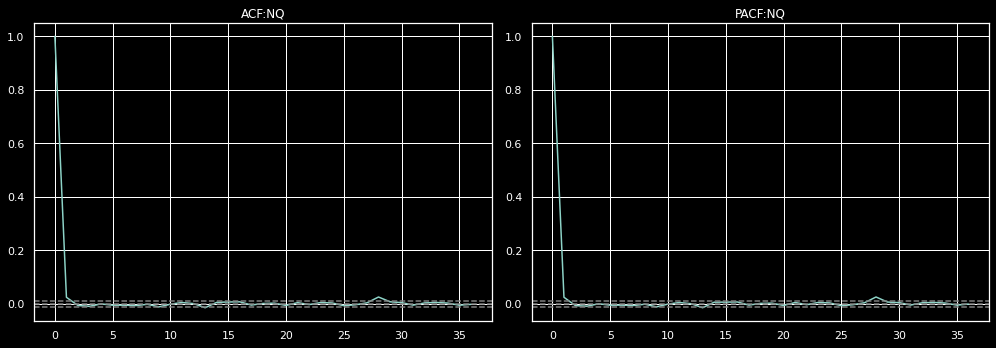

In [ ]:
import statsmodels.tsa.api as smt
acf,q,pval = smt.acf(train_trans.nq,nlags=12,qstat=True, fft=False)
pacf = smt.pacf(train_trans.nq,nlags=12)
correlogram = pd.DataFrame({'acf':acf[1:], 'pacf':pacf[1:], 'Ljung-Box Q stat':q,'p-val':pval})
print(correlogram)

from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.nq, nlags=36, fft=False)
lag_pacf = pacf(train_trans.nq, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('ACF:NQ')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('PACF:NQ')
plt.tight_layout()

We can conclude that all the series are correlated with itself shifted by 2 minutes.


### 1.2.2 Checking required lags through iteratively fitting:


<IPython.core.display.Javascript object>

Lag Order = 1
AIC :  -97.75848273934405
BIC :  -97.74661788833919
FPE :  3.4996965315130904e-43
HQIC:  -97.75467168489389 

None

Lag Order = 2
AIC :  -97.81979203921576
BIC :  -97.79775665536062
FPE :  3.291577587990007e-43
HQIC:  -97.81271414299678 

None

Lag Order = 3
AIC :  -97.8379032655281
BIC :  -97.80569673901336
FPE :  3.2324996852814573e-43
HQIC:  -97.8275583210556 

None

Lag Order = 4
AIC :  -97.84528521598807
BIC :  -97.80290693694629
FPE :  3.208725395494886e-43
HQIC:  -97.83167301675714 

None

Lag Order = 5
AIC :  -97.84790928845733
BIC :  -97.79535864696294
FPE :  3.200316512305987e-43
HQIC:  -97.83102962794283 

None

Lag Order = 6
AIC :  -97.84910288549833
BIC :  -97.7863792715677
FPE :  3.1964989133592604e-43
HQIC:  -97.8289555571549 

None

Lag Order = 7
AIC :  -97.85012390639076
BIC :  -97.77722670998212
FPE :  3.193236901382238e-43
HQIC:  -97.82670870365286 

None

Lag Order = 8
AIC :  -97.85034044206752
BIC :  -97.76726905308097
FPE :  3.192545545841919e-43
HQI

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

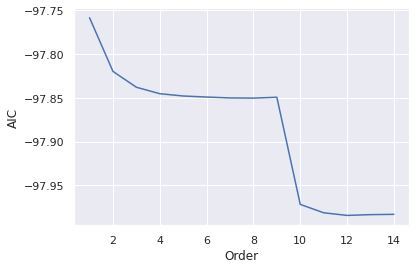

In [ ]:
from statsmodels.tsa.api import VAR
pd.options.display.float_format = "{:.2f}".format
model = VAR(train_trans.values)
"""
construct of a VAR model and enter the variables to determine
the appropriate lag length
"""
res_aic = []
for i in range (1,15):
    res = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', res.aic)
    print('BIC : ', res.bic)
    print('FPE : ', res.fpe)
    print('HQIC: ', res.hqic, '\n')
    print(res_aic.append(res.aic)); print()

import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,15,1)), res_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

From the plot, the lowest AIC score is achieved at the order of 11. Hence, we select the 11 as the optimal order of the VAR model.
- BIC drops to lowest at lag 3
- FPE drops to lowest at lag 8
- HQIC drops to lowest at lag 4

We shall try with lag 8 and lag3 to check which models proves better output.

### 1.2.3 Checking throgh VAR order selection:

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -80.25      -80.25   1.406e-35      -80.25
1       -80.50      -80.49   1.094e-35      -80.50
2       -80.56      -80.55   1.030e-35      -80.56
3       -80.58      -80.56   1.011e-35      -80.57
4       -80.59      -80.56   1.003e-35      -80.58
5       -80.59      -80.55   1.001e-35      -80.58
6       -80.59      -80.55   9.995e-36      -80.58
7       -80.59      -80.54   9.986e-36      -80.58
8       -80.59      -80.53   9.980e-36      -80.57
9       -80.59      -80.53   9.987e-36      -80.57
10      -80.71      -80.64   8.837e-36      -80.69
11      -80.72     -80.64*   8.753e-36     -80.70*
12      -80.72      -80.64   8.748e-36      -80.70
13      -80.72      -80.63   8.751e-36      -80.69
14      -80.72      -80.62   8.746e-36      -80.69
15      -80.72      -80.62   8.749e-36      -80.69
16      -80.72      -80.61   8.

<IPython.core.display.Javascript object>

BEST ORDER 31 BEST AIC: -80.75222844612321


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

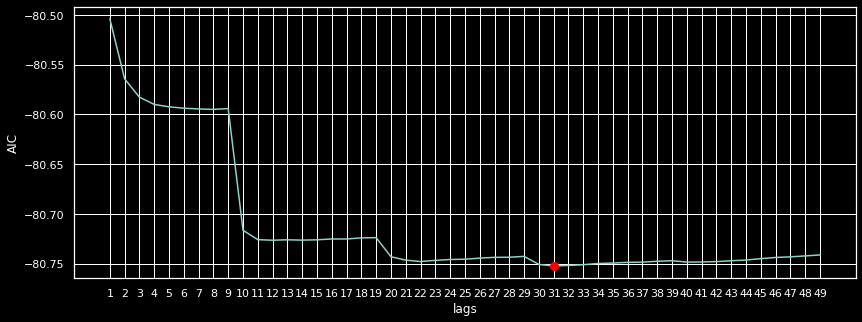

In [ ]:
x = model.select_order(maxlags=40)
print(x.summary())

# Visualization
AIC = {}
best_aic, best_order = np.inf, 0
for i in range(1,50):
    model = VAR(endog = train_trans.values).fit(maxlags=i)
    
    """
    construct of a VAR model and enter the variables to determine the appropriate lag length
    """
    AIC[i] = model.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

# Plot AICs 
plt.style.use('dark_background')
plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

- This gives AIC & FPE as 31, BIC & HQIC as 11
- We have few lag values, let us try with 2 lags.

# **2 VAR model fitting with lags 2:**

In [ ]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_2 = VAR(endog = train_trans).fit(maxlags = 2)
model_l_2.summary()

<IPython.core.display.Javascript object>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Nov, 2020
Time:                     07:24:33
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -97.7978
Nobs:                     29332.0    HQIC:                  -97.8127
Log likelihood:       1.18498e+06    FPE:                3.29158e-43
AIC:                     -97.8198    Det(Omega_mle):     3.28284e-43
--------------------------------------------------------------------
Results for equation es
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000002         0.000002            0.743           0.458
L1.es             0.013188         0.012577            1.049           0.294
L1.eurusd         0.035535         0.009283            3.828           0.000
L1

- Top of the table shows the information for the model as a whole, including values of the information criteria, 
- Further down we shows the coefficient estimates and goodness-of-fit measures for each of the equations separately. 
- Each regression equation is separated by a horizontal line.

## 2.1 Normality test of residuals:
If the residuals follow a normal distribution we expect a histogram of the residuals to be bell-shaped (with no outliers).

In [ ]:
residuals = model_l_2.resid
print(residuals.shape)
residuals.index = (residuals.index).to_timestamp()

(29332, 6)


<IPython.core.display.Javascript object>

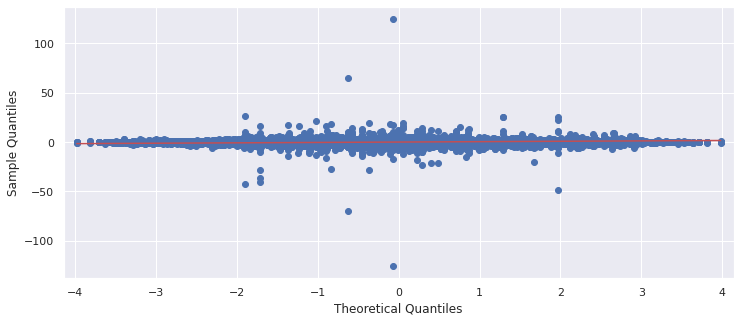

In [ ]:
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
fig = qqplot(residuals, line='q', ax=ax, fit=True)

In [ ]:
# imports the normality test from scipy.stats
from scipy.stats import normaltest
# performs the normality test on the residuals 
print(normaltest(residuals))

NormaltestResult(statistic=array([12108., 51168., 41873.,  8750., 14946., 24366.]), pvalue=array([0., 0., 0., 0., 0., 0.]))


The test rejects the hypothesis of normality (p-value < 0.05)



In [ ]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

### 2.1.1 Histogram plot:

In [ ]:
#plt.figure(figsize = (10,5))
#residuals = model_l_2.resid
#print(residuals.shape)
#plt.figure(1)
#plt.hist(residuals, bins=50, edgecolor='black',linewidth=1.2)
#plt.xlabel('Residuals'); plt.ylabel('Density');
#plt.show()

However, looking at the histogram plot, we could investigate the distribution of the residuals whether resembles a bell-shape, any outliers which might lead to a considerable negative skewness. 

With the increase the number of bins or lower the width of the bins in order to obtain a more differentiated histogram.

Unfortunately we could not perform this test because of hardware issue.

### 2.1.2 Jarque bera test:

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
lzip(name, test)

[('Jarque-Bera', array([4.e+06, 1.e+09, 6.e+08, 1.e+06, 6.e+06, 6.e+10])),
 ('Chi^2 two-tail prob.', array([0., 0., 0., 0., 0., 0.])),
 ('Skew', array([ -1., -11.,  -7.,   0.,  -1.,  -2.])),
 ('Kurtosis', array([  57., 1089.,  716.,   35.,   72., 7164.]))]

- Negative values for the skewness indicate data that are skewed left. means the left tail is long relative to the right tail.

- Kurtosis with values > 3 means data exceeding the tails of the normal distribution.

Non-normality of residuals mean that these inferences could be wrong; however, our sample size is large enough that we need be less concerned than we would with a smaller sample.

### 2.1.3 Durbin Watson Statistic:

DW test was performed with the assumption that the errors are independent. Value of 2, or close to it, is ideal. The statistical value ranges between 0-4 where a value closer to 0 is more evidence for positive serial correlation and a value closer to 4 is more evidence for negative serial correlation.

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.


In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_l_2.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.04
gbpusd : 2.01
gc : 2.0
nq : 2.0
usdjpy : 2.0


This is to determine the existence of multi-colinearity where variables are highly correlated. The statistic is a values between 0-4 and value 2 is idea, which means there is ni auto-correlation among the variables in the model.

The serial correlation looks alright. 



### 2.1.4 Residuals plot

<IPython.core.display.Javascript object>

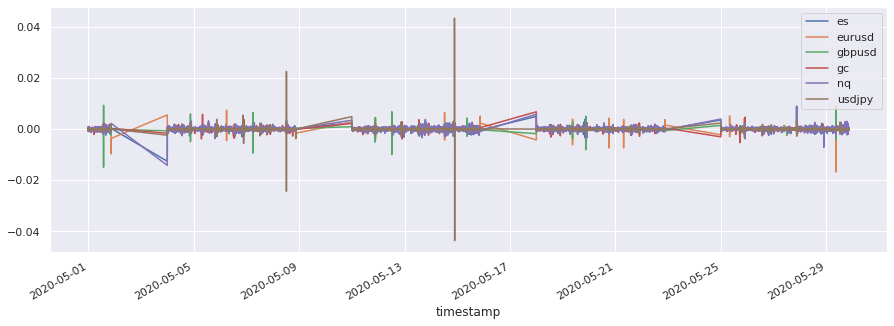

<IPython.core.display.Javascript object>

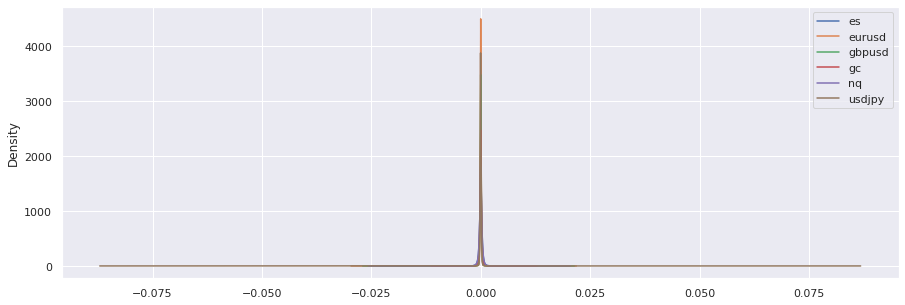

            es   eurusd   gbpusd       gc       nq   usdjpy
count 29332.00 29332.00 29332.00 29332.00 29332.00 29332.00
mean     -0.00    -0.00     0.00     0.00    -0.00     0.00
std       0.00     0.00     0.00     0.00     0.00     0.00
min      -0.01    -0.02    -0.01    -0.01    -0.01    -0.04
25%      -0.00    -0.00    -0.00    -0.00    -0.00    -0.00
50%      -0.00    -0.00     0.00    -0.00    -0.00    -0.00
75%       0.00     0.00     0.00     0.00     0.00     0.00
max       0.01     0.01     0.01     0.01     0.01     0.04


In [ ]:
# plot residual errors

res = DataFrame(residuals)
res.plot(figsize = (15,5))
plt.show()

res.plot(kind='kde', figsize = (15,5))
plt.show()

print(res.describe())

- line plot of the residual errors suggesting that model has captured the information quite well.
- density plot of the residual error values suggesting the errors are Gaussian, centered on zero.
- The distribution of the residual errors is displayed. The results show that there is no bias in the prediction (zero mean in the residuals).

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

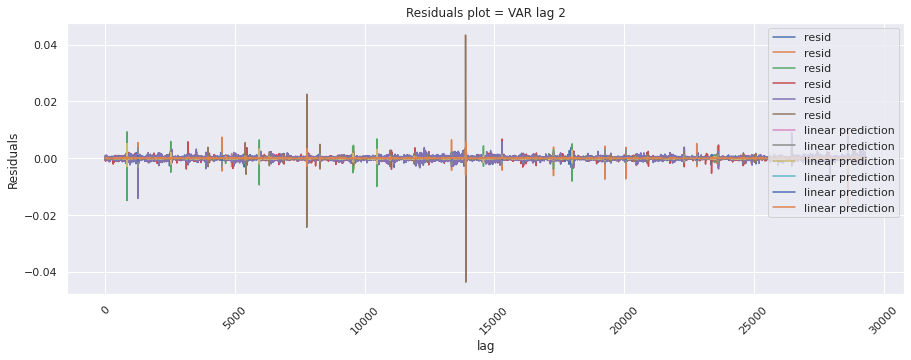

In [ ]:
y_fitted = model_l_2.fittedvalues
plt.figure(figsize = (15,5))
plt.plot(residuals.values, label='resid')
plt.plot(y_fitted.values, label='linear prediction')
plt.xlabel('lag')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.title('Residuals plot = VAR lag 2')
plt.grid(True)
plt.legend()
plt.show()

Despite failing the normality tests, the mean of the residuals are essentially 0. 

In [ ]:
# residuals sum of square (RSS)
(residuals**2).sum()

eurusd   0.00
gbpusd   0.00
gc       0.00
nq       0.00
usdjpy   0.01
dtype: float64

In [ ]:
residuals.tail

<bound method NDFrame.tail of                      eurusd  gbpusd    gc    nq  usdjpy
timestamp                                              
2020-05-01 00:03:00   -0.00   -0.00 -0.00 -0.00    0.00
2020-05-01 00:04:00    0.00   -0.00 -0.00  0.00   -0.00
2020-05-01 00:05:00    0.00   -0.00 -0.00 -0.00    0.00
2020-05-01 00:06:00   -0.00   -0.00 -0.00 -0.00   -0.00
2020-05-01 00:07:00   -0.00    0.00  0.00  0.00   -0.00
...                     ...     ...   ...   ...     ...
2020-05-29 20:46:00    0.00   -0.00  0.00  0.00   -0.00
2020-05-29 20:47:00   -0.00   -0.00 -0.00 -0.00   -0.00
2020-05-29 20:48:00    0.00   -0.00 -0.00 -0.00   -0.00
2020-05-29 20:49:00   -0.00   -0.00 -0.00  0.00   -0.00
2020-05-29 20:50:00    0.00   -0.00 -0.00  0.00   -0.00

[29332 rows x 5 columns]>

### 2.1.5 Tests for structural breaks:
Brown, Durban, and Evans (1975) proposed CUMSUM test

In [ ]:
# unexpected change over time in the parameters of regression models
name = ['test statistic', 'pval', 'crit']
test = sms.breaks_cusumolsresid(residuals.values, ddof = model_l_2.df_model)
"""
greater the CUSUM test statistic, the greater the forecast error, 
and the greater the statistical evidence in favor of parameter instability.
"""
lzip(name, test)

[('test statistic', 0.9693677688917178),
 ('pval', 0.3042923249749582),
 ('crit', [(1, 1.63), (5, 1.36), (10, 1.22)])]

- Null hypothesis (H0) = no structural break 
- The test statistic (0.68) and the corresponding p-value (0.73 > 0.05) suggest that we cannot reject H0 and our model does not have a structural break for any possible break date in the sample.
- we can conclude that our series is not abruptly changed at a point in time considering our historical data

***Ref: Ploberger, Werner, and Walter Kramer. “The Cusum Test with Ols Residuals.”***

In [ ]:
# residuals statistic
residuals.describe()

,eurusd,gbpusd,gc,nq,usdjpy
count,29332.00,29332.00,29332.00,29332.00,29332.00
mean,-0.00,0.00,0.00,-0.00,-0.00
std,0.00,0.00,0.00,0.00,0.00
min,-0.02,-0.01,-0.01,-0.01,-0.04
25%,-0.00,-0.00,-0.00,-0.00,-0.00
50%,-0.00,0.00,-0.00,-0.00,-0.00
75%,0.00,0.00,0.00,0.00,0.00
max,0.01,0.01,0.01,0.01,0.04


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

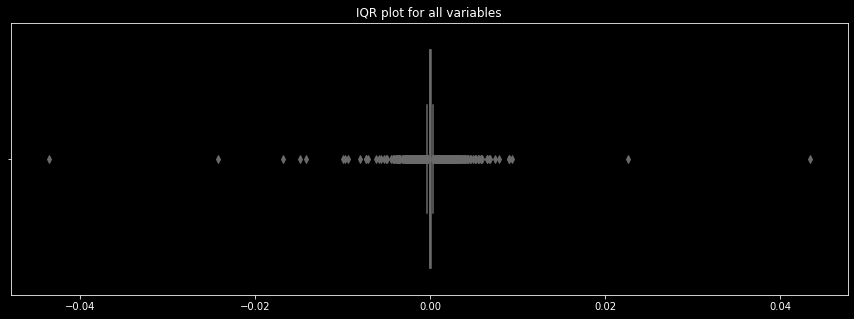

In [ ]:
plt.figure(figsize = (15,5))
plt.title('IQR plot for all variables')
sns.boxplot(x = residuals.values)
plt.show()

In [ ]:
#import statsmodels.api as sm
#sm.qqplot(residuals,fit=True,line='45')
#plt.show()

In [ ]:
# outlier values
residuals.nsmallest(n= 7, columns = residuals.columns)

,eurusd,gbpusd,gc,nq,usdjpy
timestamp,,,,,
2020-05-29 08:59:00,-0.02,0.01,0.00,0.00,-0.00
2020-05-01 20:59:00,-0.01,-0.00,-0.00,-0.00,0.00
2020-05-20 17:59:00,-0.01,0.00,-0.00,0.00,0.00
2020-05-21 07:29:00,-0.01,-0.00,0.00,0.00,0.00
2020-05-19 08:59:00,-0.01,-0.00,0.00,0.00,-0.00
2020-05-06 06:00:00,-0.00,-0.00,0.00,0.00,0.00
2020-05-14 12:30:00,-0.00,-0.00,0.00,0.00,0.00


In [ ]:
# creating dummy variables with outliers

#train_trans['dum_1'] = np.where(train_trans.index == '2020-05-29 08:59:00', 1, 0)
#train_trans['dum_2'] = np.where(train_trans.index == '2020-05-01 20:59:00', 1, 0)
#train_trans['dum_3'] = np.where(train_trans.index == '2020-05-20 17:59:00', 1, 0)
#train_trans['dum_4'] = np.where(train_trans.index == '2020-05-21 07:29:00', 1, 0)
#train_trans['dum_5'] = np.where(train_trans.index == '2020-05-19 08:59:00', 1, 0)
#print(train_trans.sample(5)); print()

In [ ]:
# sanity check
#print(train_trans.dum_1.unique())
#print(train_trans.dum_2.unique())

## 2.2 Granger causality test:

In [ ]:
print('GBPUSD-> EURUSD')
ca_1 = model_l_2.test_causality(causing=['gbpusd'], caused=['eurusd'], kind='wald',signif=0.05 )
print(ca_1)
print("**********************")
print('GBPUSD-> USDJPY')
ca_2 = model_l_2.test_causality(causing=['gbpusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_2)
print("**********************")
print('GBPUSD -> USDJPY, EURUSD')
ca_3 = model_l_2.test_causality(causing=['gbpusd'], caused=['usdjpy', 'eurusd'], kind='wald',signif=0.05 )
print(ca_3)
print("**********************")
print('EURUSD -> USDJPY')
ca_4 = model_l_2.test_causality(causing=['eurusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")
print('EURUSD -> GBPUSD, USDJPY')
ca_5 = model_l_2.test_causality(causing=['eurusd'], caused=['gbpusd', 'usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")

GBPUSD-> EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause eurusd: reject at 5% significance level. Test statistic: 279.013, critical value: 5.991>, p-value: 0.000>
**********************
GBPUSD-> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic: 4.899, critical value: 5.991>, p-value: 0.086>
**********************
GBPUSD -> USDJPY, EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause [usdjpy, eurusd]: reject at 5% significance level. Test statistic: 282.280, critical value: 9.488>, p-value: 0.000>
**********************
EURUSD -> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: eurusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic

In [ ]:
# fitting VAR model with associated freq & lags
#model_l_2_new = VAR(endog = train_trans).fit(maxlags = 2)


Let’s proceed with the forecast.

### 2.3.1 Forecasting:
We used 2 as the optimal order in fitting the VAR model. Thus, we will take the final 2 steps in the training data for forecasting the immediate next step (i.e., the first minute of the test data).

In [ ]:
train_trans.values[-2:]

array([[ 1.e-04, -2.e-04, -1.e-04, -9.e-05,  2.e-04, -7.e-05],
       [ 0.e+00,  2.e-04, -8.e-05, -9.e-05,  3.e-04, -3.e-04]])

Now, after fitting the model, we forecast for the test data where the last 2 minutes of training data set as lagged values and steps set as 10 minutes as we want to forecast for the next 10 minutes.

In [ ]:
laged_values = train_trans.values[-2:]
forecast = DataFrame(model_l_2.forecast(y= laged_values, steps=10), 
                     index = test_var.index, columns= test_var.columns + '_trans')
forecast


,es_trans,eurusd_trans,gbpusd_trans,gc_trans,nq_trans,usdjpy_trans
timestamp,,,,,,
2020-05-29 20:51:00,-0.00,-0.00,0.00,0.00,-0.00,0.00
2020-05-29 20:52:00,0.00,-0.00,-0.00,-0.00,0.00,0.00
2020-05-29 20:53:00,-0.00,0.00,-0.00,0.00,-0.00,0.00
2020-05-29 20:54:00,0.00,-0.00,0.00,0.00,0.00,-0.00
2020-05-29 20:55:00,0.00,-0.00,-0.00,0.00,0.00,0.00
2020-05-29 20:56:00,0.00,0.00,-0.00,0.00,0.00,0.00
2020-05-29 20:57:00,0.00,-0.00,-0.00,0.00,0.00,0.00
2020-05-29 20:58:00,0.00,0.00,-0.00,0.00,0.00,0.00
2020-05-29 20:59:00,0.00,0.00,-0.00,0.00,0.00,0.00


In [ ]:
def inverse_diff(train_trans, forecast):
    """Revert back the differencing"""
    df_fc = forecast.copy()
    columns = test_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_log[col].iloc[-1] + df_fc[str(col)+'_trans'].cumsum()
    return df_fc

results = inverse_diff(train_trans, forecast)        
z = results.loc[:, ['eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast', 'es_fcast']]
# Roll back log transformation
pd.options.display.float_format = "{:.2f}".format
# z = math.exp(z)
z = np.exp(z) 
# numpy exponential function on multidimensinal array; e= 2.718281(approx)
print(z)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                     eurusd_fcast  gbpusd_fcast  gc_fcast  nq_fcast  usdjpy_fcast  es_fcast
timestamp                                                                                  
2020-05-29 20:51:00    1110714.74    1235486.36   1731.81   9587.26  107779465.46   3027.11
2020-05-29 20:52:00    1110701.76    1235486.09   1731.80   9587.54  107779590.39   3027.20
2020-05-29 20:53:00    1110723.51    1235472.27   1731.80   9587.50  107779610.02   3027.18
2020-05-29 20:54:00    1110716.49    1235476.98   1731.80   9587.52  107779599.82   3027.19
2020-05-29 20:55:00    1110716.32    1235476.68   1731.80   9587.56  107779612.86   3027.20
2020-05-29 20:56:00    1110718.83    1235474.54   1731.81   9587.58  107779632.40   3027.20
2020-05-29 20:57:00    1110718.62    1235474.32   1731.81   9587.61  107779643.81   3027.21
2020-05-29 20:58:00    1110719.15    1235473.62   1731.81   9587.64  107779657.73   3027.21
2020-05-29 20:59:00    1110719.90    1235472.72   1731.81   9587.66  107779672.0

In [ ]:
# creating actual vs predicted results table
z.index = test_var.index
lag2 = concat([test_var, z], axis=1)
lag2 = lag2[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'gc','gc_fcast','nq','nq_fcast']]
lag2 = lag2.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag2.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110720.390209,1237150.000000,1235472.023536,107835000.000000,107779685.661368,1731.350000,1731.810337,9591.125000,9587.688059
2020-05-29 20:59:00,1113400.000000,1110719.900681,1235450.000000,1235472.724908,107835000.000000,107779672.033034,1731.300000,1731.809099,9587.375000,9587.661461
2020-05-29 20:58:00,1111650.000000,1110719.148885,1235450.000000,1235473.616777,107830000.000000,107779657.726438,1731.450000,1731.807856,9588.625000,9587.635509
2020-05-29 20:57:00,1111750.000000,1110718.624524,1235450.000000,1235474.317846,107830000.000000,107779643.810778,1731.200000,1731.806583,9588.500000,9587.607274
2020-05-29 20:56:00,1111740.000000,1110718.831078,1235400.000000,1235474.539020,107675000.000000,107779632.404422,1731.500000,1731.805397,9588.625000,9587.581143
2020-05-29 20:55:00,1110660.000000,1110716.315720,1234990.000000,1235476.682502,107766500.000000,107779612.862825,1731.550000,1731.804160,9587.875000,9587.561030
2020-05-29 20:54:00,1110785.000000,1110716.491147,1235090.000000,1235476.981839,107788500.000000,107779599.824365,1731.750000,1731.802638,9586.375000,9587.516919
2020-05-29 20:53:00,1110845.000000,1110723.509650,1234890.000000,1235472.273861,107784500.000000,107779610.015208,1731.750000,1731.801865,9587.875000,9587.501512
2020-05-29 20:52:00,1110745.000000,1110701.764042,1235140.000000,1235486.089729,107779000.000000,107779590.390883,1731.500000,1731.800313,9586.875000,9587.536962


***Other way of forecasting***

In [ ]:
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_2.k_ar
print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
print(input_data)

<IPython.core.display.Javascript object>

2
[[-2.e-04 -1.e-04 -9.e-05  2.e-04 -7.e-05]
 [ 2.e-04 -8.e-05 -9.e-05  3.e-04 -3.e-04]]


In [ ]:
# forecast
fc = model_l_2.forecast(y = input_data, steps = lag_order)
df_pred = DataFrame(fc, columns = train_trans.columns + '_1d')

"""
We are storing the value in numpy multidimensional array as a 64 bit floating point number.
The smallest non-zero number we can store is 2^(1-1023) = 2^-1022.
Since our obtained numbers are smaller than that, it is stored as 0.0 as shown below:
"""
print(df_pred)

   eurusd_1d  gbpusd_1d  gc_1d  nq_1d  usdjpy_1d
0      -0.00       0.00  -0.00  -0.00       0.00
1      -0.00       0.00  -0.00   0.00      -0.00


In [ ]:
# dropping dummy columns
#df_pred = df_pred.drop(columns= ['dum_1_1d', 'dum_2_1d', 'dum_3_1d', 'dum_4_1d', 'dum_5_1d'], axis=1)

# dropping ES column from train/test
train_var = train_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]
test_var = test_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]

### 2.3.2 Inverse transformation:

In [ ]:
def inverse_diff(train_trans, df_pred):
    """Revert back the differencing"""
    df_fc = df_pred.copy()
    columns = train_trans.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_log[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]
print('Roll back 1st difference:')
print(z)

Roll back 1st difference:
   eurusd_fcast  gbpusd_fcast  gc_fcast  nq_fcast  usdjpy_fcast
0         13.92         14.03      7.46      9.17         18.50
1         13.92         14.03      7.46      9.17         18.50


In [ ]:
# Roll back log transformation
pd.options.display.float_format = "{:.2f}".format

# z = math.exp(z)
z = np.exp(z) 
# numpy exponential function on multidimensinal array; e= 2.718281(approx)
print(z)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   eurusd_fcast  gbpusd_fcast  gc_fcast  nq_fcast  usdjpy_fcast
0    1110715.28    1235501.68   1731.80   9587.37  107780395.84
1    1110700.24    1235502.59   1731.79   9587.58  107780385.52


In [ ]:
#test_var.index[:2]

In [ ]:
# creating actual vs predicted results table
z.index = test_var.index[:2]
lag2 = pd.concat([test_var[:2], z], axis=1)
lag2 = lag2[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'gc','gc_fcast','nq','nq_fcast']]
lag2 = lag2.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag2.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,
2020-05-29 20:52:00,1110745.000000,1110700.237503,1235140.000000,1235502.593537,107779000.000000,107780385.516800,1731.500000,1731.793555,9586.875000,9587.580003
2020-05-29 20:51:00,1110660.000000,1110715.278932,1235245.000000,1235501.675746,107773500.000000,107780395.836698,1731.850000,1731.798506,9587.375000,9587.370301


In [ ]:
#def inverse_diff(actual_df, pred_df):
  #df_res = pred_df.copy()
  #columns = actual_df.columns
  #for col in columns:
    #df_res[str(col)+'_pred'] = actual_
    #df[col].iloc[-1] + df_res[str(col)].cumsum()
  #return df_res

#res = inverse_diff(df[['es','eurusd','gbpusd','gc','nq', 'usdjpy']], df_pred)
#res

### 2.3.3 Accuracy Metrics: VAR Lag 2

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag2.eurusd, lag2.eurusd_fcast)
mse = mean_squared_error(lag2.eurusd, lag2.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['eurusd'].values - lag2['eurusd_fcast'].values) / lag2['eurusd'].values)) * 100
msle = mean_squared_log_error(lag2.eurusd, lag2.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag2.gbpusd, lag2.gbpusd_fcast)
mse = mean_squared_error(lag2.gbpusd, lag2.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['gbpusd'].values - lag2['gbpusd_fcast'].values) / lag2['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag2.gbpusd, lag2.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag2.usdjpy, lag2.usdjpy_fcast)
mse = mean_squared_error(lag2.usdjpy, lag2.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['usdjpy'].values - lag2['usdjpy_fcast'].values) / lag2['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag2.usdjpy, lag2.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag2.nq, lag2.nq_fcast)
mse = mean_squared_error(lag2.nq, lag2.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['nq'].values - lag2['nq_fcast'].values) / lag2['nq'].values)) * 100
msle = mean_squared_log_error(lag2.nq, lag2.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag2.gc, lag2.gc_fcast)
mse = mean_squared_error(lag2.gc, lag2.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['gc'].values - lag2['gc_fcast'].values) / lag2['gc'].values)) * 100
msle = mean_squared_log_error(lag2.gc, lag2.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
sum


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Accuracy metrics : EURUSD,GBPUSD,USDJPY,NQ,GC
Mean Absolute Error,50.02,309.63,4140.68,0.35,0.17
Mean squared error,2529.72,98678.26,24736110.28,0.25,0.04
Root mean squared error,50.30,314.13,4973.54,0.50,0.21
Mean absolute % error,0.00,0.03,0.00,0.00,0.01
Mean squared log Error,0.00,0.00,0.00,0.00,0.00


#### 2.3.3.1 Forcast validation

In [ ]:
# EURUSD forcast validation
m = lag2.loc[:, ['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 20:52:00,1110745.000000,1110700.238000,100.00%
2020-05-29 20:51:00,1110660.000000,1110715.279000,100.00%


In [ ]:
#error_eurusd = (lag2.eurusd - lag2.eurusd_fcast)
# plot residuals
#error_eurusd.plot()
#plt.title('error plot :: EURUSD')
#plt.show()
#print()
#print('Mean of error:', error_eurusd.mean())

Running the example shows a seemingly random plot of the residual time series.

- The error is the difference between the observed data of the outcome variable 𝑦 and the predicted values 𝑦̂ error = 𝑦 − 𝑦̂
- The residuals plot should look “random” (no discernible pattern)
- if the residuals are not random, they suggest that our model is systematically incorrect, meaning it can be improved

Mean error value 57 (not close enough to zero). It suggests that there may be some bias and that we may be able to further improve the model by performing a bias correction. This could be done by adding the mean residual error (57.68)
to forecasts.



In [ ]:
## histogram plot
#error_eurusd.hist()
#plt.show()
# density plot
#error_eurusd.plot(kind='kde')
#plt.show()

One assumption underlying linear regression is that the variance of the errors is normally distributed (follows a Gaussian distribution).

The distribution does have a Gaussian look, showing an exponential distribution with some asymmetry. This confirms that that assumptions made by the modeling process seems in the right direction.



In [ ]:
# Our expectation here is to have any correlation between the error.

#from pandas.plotting import autocorrelation_plot

#autocorrelation_plot(DataFrame(error_eurusd))
#plt.title('Correlation: Error plot')
#plt.show()

We see some significant autocorrelation trend across the plot.Significant autocorrelation in the error plot suggests that the model good at incorporating the relationship between observations and lagged observations.

In [ ]:
error_eurusd_lag2 = (lag2.eurusd - lag2.eurusd_fcast).mean()
print('error_eurusd (lag2):', error_eurusd_lag2)
error_gbpusd_lag2 = (lag2.gbpusd - lag2.gbpusd_fcast).mean()
print('error_gbpusd (lag2):', error_gbpusd_lag2)
error_usdjpy_lag2 = (lag2.usdjpy - lag2.usdjpy_fcast).mean()
print('error_usdjpy (lag2):', error_usdjpy_lag2)
error_gc_lag2 = (lag2.gc - lag2.gc_fcast).mean()
print('error_gc (lag2):', error_gc_lag2)
error_nq_lag2 = (lag2.nq - lag2.nq_fcast).mean()
print('error_nq (lag2):', error_nq_lag2)


error_eurusd (lag2): -5.258217272814363
error_gbpusd (lag2): -309.634641383891
error_usdjpy (lag2): -4140.676749140024
error_gc (lag2): -0.12103048101312197
error_nq (lag2): -0.3501521639946077


We have identifiued the error values; though values are quite low, however, we can add these values with the respective forecasted values to reduce the error.



# **3 VAR model fitting with lag 11:**

In [ ]:
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

nobs=5
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
#print(train_var.shape, test_var.shape); print()

# transfoming training data set
train_log = np.log(train_var) # log transformation
train_trans = train_log.diff().dropna() # 1st order differencing
#print('Description of diff data:'); print(train_trans.describe());

# droppping ES variable
train_trans.drop(columns = ['es'], axis=1, inplace=True)


import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_11 = VAR(endog = train_trans).fit(maxlags = 11) # BIC = 11

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(29328, 5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

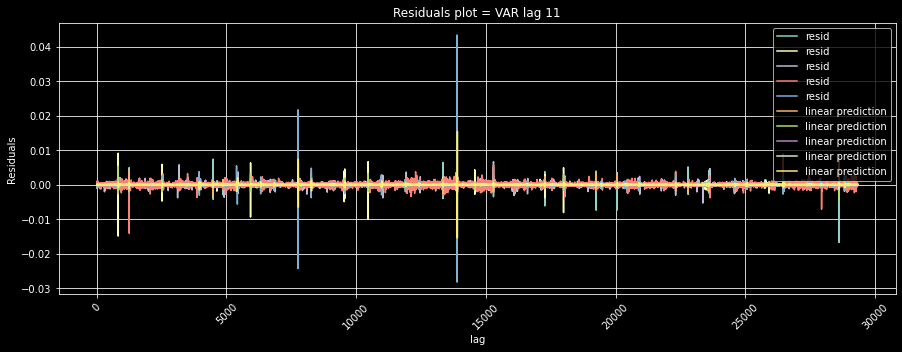

In [ ]:
residuals = model_l_11.resid
print(residuals.shape)
residuals.index = (residuals.index).to_timestamp()

y_fitted = model_l_11.fittedvalues
plt.figure(figsize = (15,5))
plt.plot(residuals.values, label='resid')
plt.plot(y_fitted.values, label='linear prediction')
plt.xlabel('lag')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.title('Residuals plot = VAR lag 11')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# test for structural breaks
name = ['test statistic', 'pval', 'crit']
test = sms.breaks_cusumolsresid(residuals.values, ddof = model_l_11.df_model)
lzip(name, test)

[('test statistic', 0.7573231580178857),
 ('pval', 0.6148530208929261),
 ('crit', [(1, 1.63), (5, 1.36), (10, 1.22)])]

In [ ]:
# residuals statistic
residuals.describe()

,eurusd,gbpusd,gc,nq,usdjpy
count,29328.00,29328.00,29328.00,29328.00,29328.00
mean,0.00,-0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00
min,-0.02,-0.01,-0.01,-0.01,-0.03
25%,-0.00,-0.00,-0.00,-0.00,-0.00
50%,0.00,0.00,0.00,-0.00,-0.00
75%,0.00,0.00,0.00,0.00,0.00
max,0.01,0.01,0.01,0.01,0.04


In [ ]:
from statsmodels.stats.stattools import durbin_watson
#print('Durbin Watson statistic:')
#out = durbin_watson(model_l_12.resid)

#for col, val in zip(train_var.columns, out):
    #print((col), ':', round(val, 2))
print()

# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_11.k_ar
#print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

fc = model_l_11.forecast(y = input_data, steps = nobs)
df_pred = DataFrame(fc, columns = train_trans.columns + '_1d')
#print(df_pred)


# dropping ES column from train/test
train_var = train_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]
test_var = test_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]

def inverse_diff(train_trans, df_pred):
    """Revert back the differencing"""
    df_fc = df_pred.copy()
    columns = train_trans.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_log[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]

# Roll back log transformation
pd.options.display.float_format = "{:.2f}".format
z = np.exp(z)
#print(z)

print('Actual vs forecast:')
z.index = test_var.index
lag11 = pd.concat([test_var, z], axis=1)
lag11 = lag11[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'gc','gc_fcast','nq','nq_fcast']]
lag11 = lag11.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag11.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Actual vs forecast:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110677.978943,1237150.000000,1235042.055676,107835000.000000,107797033.571834,1731.350000,1731.568519,9591.125000,9587.712159
2020-05-29 20:59:00,1113400.000000,1110680.880642,1235450.000000,1235050.049743,107835000.000000,107786211.387679,1731.300000,1731.557374,9587.375000,9587.736992
2020-05-29 20:58:00,1111650.000000,1110679.218817,1235450.000000,1235045.607309,107830000.000000,107780178.699472,1731.450000,1731.548131,9588.625000,9587.868443
2020-05-29 20:57:00,1111750.000000,1110682.734422,1235450.000000,1235041.173868,107830000.000000,107775591.492108,1731.200000,1731.536759,9588.500000,9587.916442
2020-05-29 20:56:00,1111740.000000,1110680.320401,1235400.000000,1235030.314931,107675000.000000,107774242.613842,1731.500000,1731.544196,9588.625000,9588.080524


In [ ]:
# EURUSD forcast validation
print('EURUSD forcast validation:')
m = lag11.loc[:, ['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
#m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


EURUSD forcast validation:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110677.979000,99.76%
2020-05-29 20:59:00,1113400.000000,1110680.881000,99.76%
2020-05-29 20:58:00,1111650.000000,1110679.219000,99.91%
2020-05-29 20:57:00,1111750.000000,1110682.734000,99.90%
2020-05-29 20:56:00,1111740.000000,1110680.320000,99.90%


In [ ]:
# Accuracy metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag11.eurusd, lag11.eurusd_fcast)
mse = mean_squared_error(lag11.eurusd, lag11.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag11['eurusd'].values - lag11['eurusd_fcast'].values) / lag11['eurusd'].values)) * 100
msle = mean_squared_log_error(lag11.eurusd, lag11.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag11.gbpusd, lag11.gbpusd_fcast)
mse = mean_squared_error(lag11.gbpusd, lag11.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag11['gbpusd'].values - lag11['gbpusd_fcast'].values) / lag11['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag11.gbpusd, lag11.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag11.usdjpy, lag11.usdjpy_fcast)
mse = mean_squared_error(lag11.usdjpy, lag11.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag11['usdjpy'].values - lag11['usdjpy_fcast'].values) / lag11['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag11.usdjpy, lag11.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag11.nq, lag11.nq_fcast)
mse = mean_squared_error(lag11.nq, lag11.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag11['nq'].values - lag11['nq_fcast'].values) / lag11['nq'].values)) * 100
msle = mean_squared_log_error(lag11.nq, lag11.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag11.gc, lag11.gc_fcast)
mse = mean_squared_error(lag11.gc, lag11.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag11['gc'].values - lag11['gc_fcast'].values) / lag11['gc'].values)) * 100
msle = mean_squared_log_error(lag11.gc, lag11.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
print('Accuracy metrics:')
print(sum); print()

print('error to be added with forecasted values:'); print()
error_eurusd_lag11 = (lag11.eurusd - lag11.eurusd_fcast).mean()
print('error_eurusd (lag11):', error_eurusd_lag11)
error_gbpusd_lag11 = (lag11.gbpusd - lag11.gbpusd_fcast).mean()
print('error_gbpusd (lag11):', error_gbpusd_lag11)
error_usdjpy_lag11 = (lag11.usdjpy - lag11.usdjpy_fcast).mean()
print('error_usdjpy (lag11):', error_usdjpy_lag11)
error_gc_lag11 = (lag11.gc - lag11.gc_fcast).mean()
print('error_gc (lag11):', error_gc_lag11)
error_nq_lag11 = (lag11.nq - lag11.nq_fcast).mean()
print('error_nq (lag11):', error_nq_lag11)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics:
                         Accuracy metrics :    EURUSD     GBPUSD        USDJPY   NQ   GC
Mean Absolute Error                           1707.77     738.16      58045.49 1.13 0.19
Mean squared error                         3601480.30 1014145.76 3822664495.88 2.60 0.05
Root mean squared error                       1897.76    1007.05      61827.70 1.61 0.22
Mean absolute % error                            0.15       0.06          0.05 0.01 0.01
Mean squared log Error                           0.00       0.00          0.00 0.00 0.00

error to be added with forecasted values:

error_eurusd (lag11): 1707.7733550621197
error_gbpusd (lag11): 738.1596945646219
error_usdjpy (lag11): 18348.447013005614
error_gc (lag11): -0.19099587253003847
error_nq (lag11): 0.987088074703206


# **5 VAR model fitting with lag 31:**

In [ ]:
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# spliting train/test
nobs = 5 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
#print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_log = np.log(train_var) # log transformation
train_trans = train_log.diff().dropna() # 1st order differencing
#print('Description of diff data:'); print(train_trans.describe())

# droppping ES variable
train_trans.drop(columns = ['es'], axis=1, inplace=True)


import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_31 = VAR(endog = train_trans).fit(maxlags = 31)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(29308, 5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

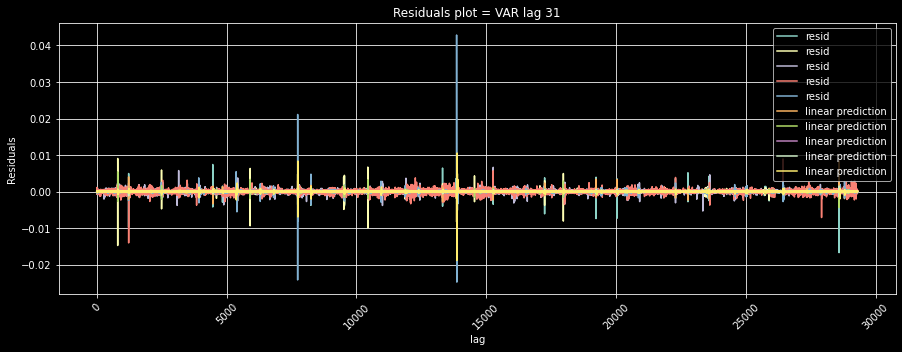

In [ ]:
residuals = model_l_31.resid
print(residuals.shape)
residuals.index = (residuals.index).to_timestamp()

y_fitted = model_l_31.fittedvalues
plt.figure(figsize = (15,5))
plt.plot(residuals.values, label='resid')
plt.plot(y_fitted.values, label='linear prediction')
plt.xlabel('lag')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.title('Residuals plot = VAR lag 31')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# test for structural breaks
name = ['test statistic', 'pval', 'crit']
test = sms.breaks_cusumolsresid(residuals.values, ddof = model_l_31.df_model)
lzip(name, test)

[('test statistic', 0.8478985069658826),
 ('pval', 0.4685173602665966),
 ('crit', [(1, 1.63), (5, 1.36), (10, 1.22)])]

In [ ]:
# residuals statistic
residuals.describe()

,eurusd,gbpusd,gc,nq,usdjpy
count,29308.00,29308.00,29308.00,29308.00,29308.00
mean,0.00,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00
min,-0.02,-0.01,-0.01,-0.01,-0.02
25%,-0.00,-0.00,-0.00,-0.00,-0.00
50%,-0.00,-0.00,0.00,-0.00,-0.00
75%,0.00,0.00,0.00,0.00,0.00
max,0.01,0.01,0.01,0.01,0.04


In [ ]:
# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_31.k_ar
#print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

fc = model_l_31.forecast(y = input_data, steps = nobs)
df_pred = DataFrame(fc, columns = train_trans.columns + '_1d')
#print(df_pred)


# dropping ES column from train/test
train_var = train_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]
test_var = test_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]

# dropping ES column from train/test
train_var = train_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]
test_var = test_var[['eurusd', 'gbpusd','usdjpy','nq','gc']]

def inverse_diff(train_trans, df_pred):
    """Revert back the differencing"""
    df_fc = df_pred.copy()
    columns = train_trans.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_log[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]

# Roll back log transformation
pd.options.display.float_format = "{:.2f}".format
z = np.exp(z)

print('Actual vs forecast:')
z.index = test_var.index
lag31 = concat([test_var, z], axis=1)
lag31 = lag31[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'gc','gc_fcast','nq','nq_fcast']]
lag31 = lag31.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag31.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Actual vs forecast:


<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110673.300957,1237150.000000,1235054.769608,107835000.000000,107815296.035188,1731.350000,1731.624733,9591.125000,9588.423441
2020-05-29 20:59:00,1113400.000000,1110681.283639,1235450.000000,1235056.398333,107835000.000000,107802564.370916,1731.300000,1731.601477,9587.375000,9588.066845
2020-05-29 20:58:00,1111650.000000,1110680.353920,1235450.000000,1235064.549320,107830000.000000,107789736.673173,1731.450000,1731.592848,9588.625000,9588.030149
2020-05-29 20:57:00,1111750.000000,1110678.999053,1235450.000000,1235054.444903,107830000.000000,107780987.659347,1731.200000,1731.570531,9588.500000,9588.133115
2020-05-29 20:56:00,1111740.000000,1110677.166909,1235400.000000,1235038.966425,107675000.000000,107775750.811280,1731.500000,1731.600058,9588.625000,9588.252929


In [ ]:
# EURUSD forcast validation
print('EURUSD forcast validation:')
m = lag31.loc[:, ['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
#m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])

EURUSD forcast validation:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110673.301000,99.76%
2020-05-29 20:59:00,1113400.000000,1110681.284000,99.76%
2020-05-29 20:58:00,1111650.000000,1110680.354000,99.91%
2020-05-29 20:57:00,1111750.000000,1110678.999000,99.90%
2020-05-29 20:56:00,1111740.000000,1110677.167000,99.90%


In [ ]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag31.eurusd, lag31.eurusd_fcast)
mse = mean_squared_error(lag31.eurusd, lag31.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['eurusd'].values - lag31['eurusd_fcast'].values) / lag31['eurusd'].values)) * 100
msle = mean_squared_log_error(lag31.eurusd, lag31.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag31.gbpusd, lag31.gbpusd_fcast)
mse = mean_squared_error(lag31.gbpusd, lag31.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['gbpusd'].values - lag31['gbpusd_fcast'].values) / lag31['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag31.gbpusd, lag31.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag31.usdjpy, lag31.usdjpy_fcast)
mse = mean_squared_error(lag31.usdjpy, lag31.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['usdjpy'].values - lag31['usdjpy_fcast'].values) / lag31['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag31.usdjpy, lag31.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag31.nq, lag31.nq_fcast)
mse = mean_squared_error(lag31.nq, lag31.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['nq'].values - lag31['nq_fcast'].values) / lag31['nq'].values)) * 100
msle = mean_squared_log_error(lag31.nq, lag31.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag31.gc, lag31.gc_fcast)
mse = mean_squared_error(lag31.gc, lag31.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['gc'].values - lag31['gc_fcast'].values) / lag31['gc'].values)) * 100
msle = mean_squared_log_error(lag31.gc, lag31.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
print('Accuracy metrics:')
print(sum); print()

print('error to be added with forecasted values:'); print()
error_eurusd_lag31 = (lag31.eurusd - lag31.eurusd_fcast).mean()
print('error_eurusd (lag31):', error_eurusd_lag31)
error_gbpusd_lag31 = (lag31.gbpusd - lag31.gbpusd_fcast).mean()
print('error_gbpusd (lag31):', error_gbpusd_lag31)
error_usdjpy_lag31 = (lag31.usdjpy - lag31.usdjpy_fcast).mean()
print('error_usdjpy (lag31):', error_usdjpy_lag31)
error_gc_lag31 = (lag31.gc - lag31.gc_fcast).mean()
print('error_gc (lag31):', error_gc_lag31)
error_nq_lag31 = (lag31.nq - lag31.nq_fcast).mean()
print('error_nq (lag31):', error_nq_lag31)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics:
                         Accuracy metrics :    EURUSD    GBPUSD        USDJPY   NQ   GC
Mean Absolute Error                           1709.78    726.17      48433.21 0.95 0.24
Mean squared error                         3608635.41 996058.79 3122877452.07 1.68 0.07
Root mean squared error                       1899.64    998.03      55882.71 1.30 0.26
Mean absolute % error                            0.15      0.06          0.04 0.01 0.01
Mean squared log Error                           0.00      0.00          0.00 0.00 0.00

error to be added with forecasted values:

error_eurusd (lag31): 1709.7791045480874
error_gbpusd (lag31): 726.1742822157219
error_usdjpy (lag31): 8132.8900190472605
error_gc (lag31): -0.23792936942472806
error_nq (lag31): 0.6687042509940511


# **6 Out of sample forecast:**


In [ ]:
print('.......load necessary libraries......')
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
from termcolor import colored
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
import sklearn.externals
import joblib
import math

.......load necessary libraries......


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print()
print(colored('OUT OF SAMPLE FUTURE PREDICTION:', 'blue', attrs=['bold']))
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0', 'es'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# transfoming training data set
df_log = np.log(df) # log transformation
df_trans = df_log.diff().dropna() # 1st order differencing
#print('Description of diff data:'); print(df_trans.describe());

# pass "1min" frequency
df_trans.index = pd.DatetimeIndex(df_trans.index).to_period('1min')

max_lags = int(2)
# fitting VAR model with associated freq & lags
model_oos = VAR(endog = df_trans).fit(maxlags = max_lags)

# Save model to file in the current working directory
joblib_file = "joblib_ALVAR_model.pkl"  
joblib.dump(model_oos, joblib_file)

# Load from file
joblib_ALVAR_model = joblib.load(joblib_file)

# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = joblib_ALVAR_model.k_ar # lag order =2
#print(lag_order) 

# Input data for forecasting
input_data = df_trans.values[-lag_order:]
#print(input_data)

# Input data for forecasting
input_data = df_trans.values[-lag_order:]
#print(input_data)

fc = joblib_ALVAR_model.forecast(y = input_data, steps = max_lags)
df_pred = DataFrame(fc, columns = df_trans.columns + '_1d')
#print(df_pred)

def inverse_diff(df_trans, df_pred):
    """Revert back the differencing"""
    df_fc = df_pred.copy()
    columns = df_trans.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = df_log[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(df_trans, df_pred)        
z = df_results.loc[:, ['eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]

# Roll back log transformation
pd.options.display.float_format = "{:.2f}".format
z = np.exp(z) 
# numpy exponential function on our multidimensional array; e= 2.718281(approx)

"""
we have 2 future values now; we have to index these values with future timestamp
"""

d = df.tail(max_lags)
d.reset_index(inplace = True)
d = d.append(DataFrame({'timestamp': pd.date_range(start = d.timestamp.iloc[-1], 
                                             periods = (len(d)+1), freq = '1min', closed = 'right')}))
d.set_index('timestamp', inplace = True)
d = d.tail(max_lags)
z.index = d.index
print(colored('THESE ARE NEXT 2 MINUTES PREDICTION:', 'red', attrs=['bold']))
#print(z); print()

# Adding training error to reduce prediction error:
#print('EURUSD forecast:')
eurusd_fcast = z.eurusd_fcast + error_eurusd_lag2
#print(eurusd_fcast); print()

#print('GBPUSD forecast:')
gbpusd_fcast = z.gbpusd_fcast + error_gbpusd_lag2
#print(gbpusd_fcast); print()

#print('USDJPY forecast:')
usdjpy_fcast = z.usdjpy_fcast + error_gbpusd_lag2
#print(usdjpy_fcast); print()

#print('GC forecast:')
gc_fcast = z.gc_fcast + error_gc_lag2
#print(gc_fcast); print()

#print('NQ forecast:')
nq_fcast = z.nq_fcast + error_nq_lag2
#print(nq_fcast); print()

concat([eurusd_fcast, gbpusd_fcast, usdjpy_fcast, nq_fcast, gc_fcast], axis=1)


OUT OF SAMPLE FUTURE PREDICTION:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

THESE ARE NEXT 2 MINUTES PREDICTION:


,eurusd_fcast,gbpusd_fcast,usdjpy_fcast,nq_fcast,gc_fcast
timestamp,,,,,
2020-05-29 21:01:00,1113237.50,1236388.46,107831998.19,9592.38,1731.28
2020-05-29 21:02:00,1113349.23,1236316.65,107833561.95,9592.30,1731.25
